In [ ]:
import psycopg2
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Basics Data Preprocessing

### Reading the data using pandas

In [ ]:
# Step 1: Redshift connection parameters

host = "default-workgroup.473183365020.ap-south-1.redshift-serverless.amazonaws.com"

port = 5439

dbname = "dev"

user = "admin"         #  Replace with your Redshift user

password = "Aryan1234"     #  Replace with your Redshift password
 
# Step 2: Connect to Redshift

try:

    conn = psycopg2.connect(

        host=host,

        port=port,

        dbname=dbname,

        user=user,

        password=password

    )

    print("Connected to Redshift successfully!")

except Exception as e:

    print(" Failed to connect:", e)

    raise
 
# Step 3: Define the SQL query

query = "SELECT * FROM leads;"  #  Replace with actual schema and table
 
# Step 4: Fetch data into a pandas DataFrame

try:

    df = pd.read_sql_query(query, conn)

    print(f"Data imported successfully! Shape: {df.shape}")

except Exception as e:

    print("Failed to execute query:", e)

    raise

finally:

    conn.close()

    print("Connection closed.")

In [ ]:
df = df.loc[:, ~df.columns.duplicated()]

# Then drop unnecessary ones
df.drop(columns=[
    'newspaper_article',
    'receivemoreupdatesaboutourcourse',
    'pageviewspervisit_float'
], errors='ignore', inplace=True)

# Mapping of old column names to new column names
column_rename_map = {
    'prospectid': 'Prospect ID',
    'leadnumber': 'Lead Number',
    'leadorigin': 'Lead Origin',
    'leadsource': 'Lead Source',
    'donotemail': 'Do Not Email',
    'donotcall': 'Do Not Call',
    'converted': 'Converted',
    'totalvisits': 'TotalVisits',
    'totaltimespentonwebsite': 'Total Time Spent on Website',
    'pageviewspervisit': 'Page Views Per Visit',
    'lastactivity': 'Last Activity',
    'country': 'Country',
    'specialization': 'Specialization',
    'howdidyouhearaboutxeducation': 'How did you hear about X Education',
    'whatisyourcurrentoccupation': 'What is your current occupation',
    'whatmattersmosttoyouinchoosingacourse': 'What matters most to you in choosing a course',
    'search': 'Search',
    'magazine': 'Magazine',
    'newspaperarticle': 'Newspaper Article',
    'xeducationforums': 'X Education Forums',
    'newspaper': 'Newspaper',
    'digitaladvertisement': 'Digital Advertisement',
    'throughrecommendations': 'Through Recommendations',
    'receivemoreupdatesaboutourcourses': 'Receive More Updates About Our Courses',
    'tags': 'Tags',
    'leadquality': 'Lead Quality',
    'updatemeonsupplychaincontent': 'Update me on Supply Chain Content',
    'getupdatesondmcontent': 'Get updates on DM Content',
    'leadprofile': 'Lead Profile',
    'city': 'City',
    'asymmetriqueactivityindex': 'Asymmetrique Activity Index',
    'asymmetriqueprofileindex': 'Asymmetrique Profile Index',
    'asymmetriqueactivityscore': 'Asymmetrique Activity Score',
    'asymmetriqueprofilescore': 'Asymmetrique Profile Score',
    'iagreetopaytheamountthroughcheque': 'I agree to pay the amount through cheque',
    'afreecopyofmasteringtheinterview': 'A free copy of Mastering The Interview',
    'lastnotableactivity': 'Last Notable Activity'
}

# Apply the renaming
df.rename(columns=column_rename_map, inplace=True)

In [42]:
df.shape  # This prints the number of rows and columns present in the dataset

(9240, 37)

In [43]:
df.describe()     #This descibes the data

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [44]:
df.isnull().sum()  # This counts the number of null values present in the dataset

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   1438
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

In [45]:
# Map Binary Columns
binary_cols = ['Do Not Email', 'Do Not Call', 'Receive More Updates About Our Courses', 'A free copy of Mastering The Interview']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

In [46]:
# Fill missing categorical with 'Unknown'
cat_cols = ['Lead Source', 'Last Activity', 'Specialization', 'What is your current occupation', 'City', 'Last Notable Activity']
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')

In [47]:
# Fill missing numeric with median
df['TotalVisits'] = df['TotalVisits'].fillna(df['TotalVisits'].median())
df['Page Views Per Visit'] = df['Page Views Per Visit'].fillna(df['Page Views Per Visit'].median())


In [48]:
# Drop IDs
df.drop(['Prospect ID', 'Lead Number'], axis=1, inplace=True)

In [49]:
# Fill Country with 'Unknown'
df['Country'] = df['Country'].fillna('Unknown')

# Drop the other columns with heavy missing + low business impact
cols_to_drop = ['How did you hear about X Education', 
                'What matters most to you in choosing a course',
                'Tags', 'Lead Quality', 'Lead Profile',
                'Asymmetrique Activity Index', 'Asymmetrique Profile Index',
                'Asymmetrique Activity Score', 'Asymmetrique Profile Score']

df.drop(columns=cols_to_drop, inplace=True)

In [50]:
df.isnull().sum()    # now the data is cleaned

Lead Origin                                 0
Lead Source                                 0
Do Not Email                                0
Do Not Call                                 0
Converted                                   0
TotalVisits                                 0
Total Time Spent on Website                 0
Page Views Per Visit                        0
Last Activity                               0
Country                                     0
Specialization                              0
What is your current occupation             0
Search                                      0
Magazine                                    0
Newspaper Article                           0
X Education Forums                          0
Newspaper                                   0
Digital Advertisement                       0
Through Recommendations                     0
Receive More Updates About Our Courses      0
Update me on Supply Chain Content           0
Get updates on DM Content         

# EDA

### Univariate Analysis

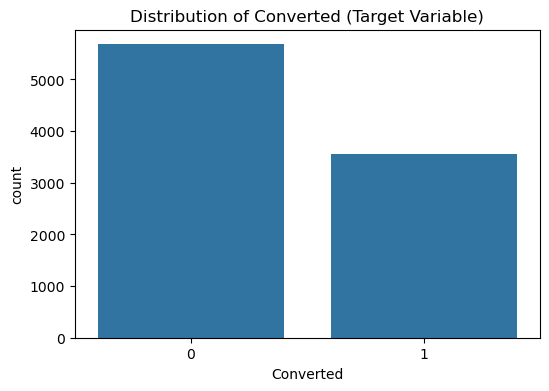

Converted
0    61.461039
1    38.538961
Name: proportion, dtype: float64


In [51]:
# Target Variable Distribution

plt.figure(figsize=(6,4)) # Total size of the figure will occupy
sns.countplot(x='Converted', data=df)  # This will give count plot
plt.title('Distribution of Converted (Target Variable)')
plt.show()

# Check balance in %
print(df['Converted'].value_counts(normalize=True) * 100)

In [52]:
# To check for the skewness

# 1. Select only numeric columns from your DataFrame
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# 2. Compute skewness for each of those columns
skewness_values = df[numeric_cols].skew().sort_values(ascending=False)

# 3. Print all skewness values
print("Skewness in Numerical Features:")
print(skewness_values)

# 4. Highlight only the highly skewed ones (optional threshold: |skew| > 1)
high_skew = skewness_values[abs(skewness_values) > 1]
print("\nHighly Skewed Features (|skew| > 1):")
print(high_skew)

Skewness in Numerical Features:
Do Not Call                               67.959544
TotalVisits                               20.061230
Do Not Email                               3.110947
Page Views Per Visit                       2.898954
Total Time Spent on Website                0.956450
A free copy of Mastering The Interview     0.808899
Converted                                  0.471058
Receive More Updates About Our Courses     0.000000
dtype: float64

Highly Skewed Features (|skew| > 1):
Do Not Call             67.959544
TotalVisits             20.061230
Do Not Email             3.110947
Page Views Per Visit     2.898954
dtype: float64


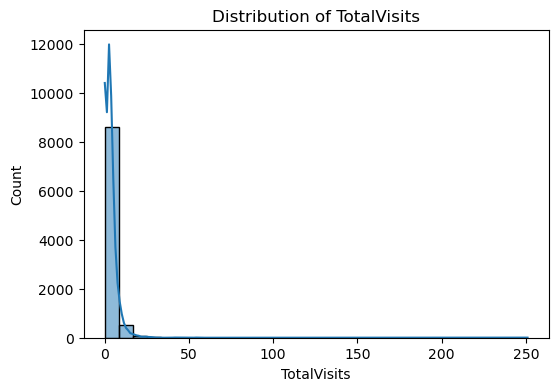

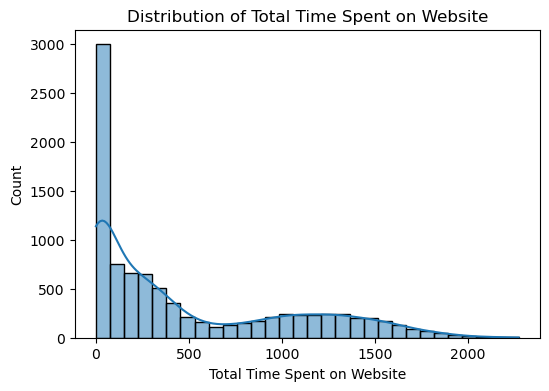

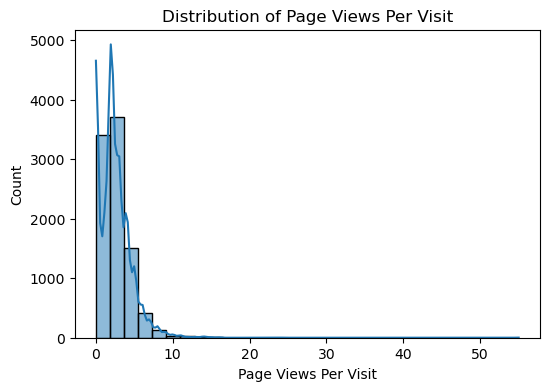

In [53]:
# Numeric Feature analysis

numeric_cols = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

for col in numeric_cols:
    plt.figure(figsize=(6,4))  # Total size of the figure
    sns.histplot(df[col], bins=30, kde=True)  # Histogram Plot
    plt.title(f'Distribution of {col}')
    plt.show()

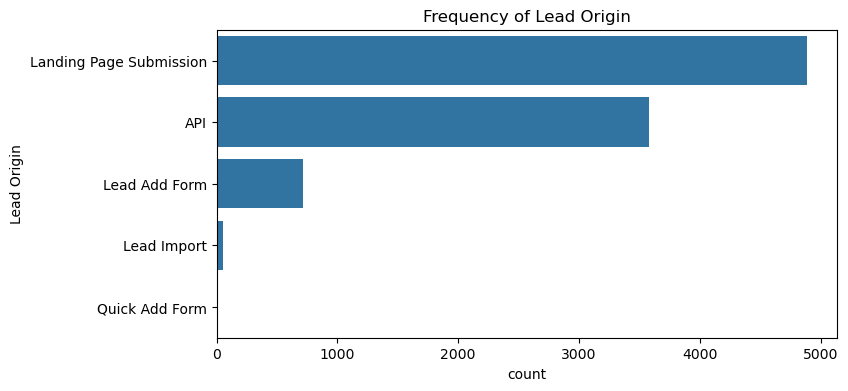

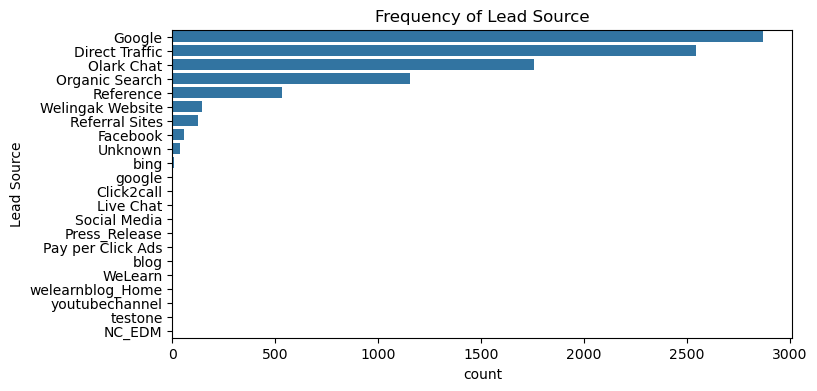

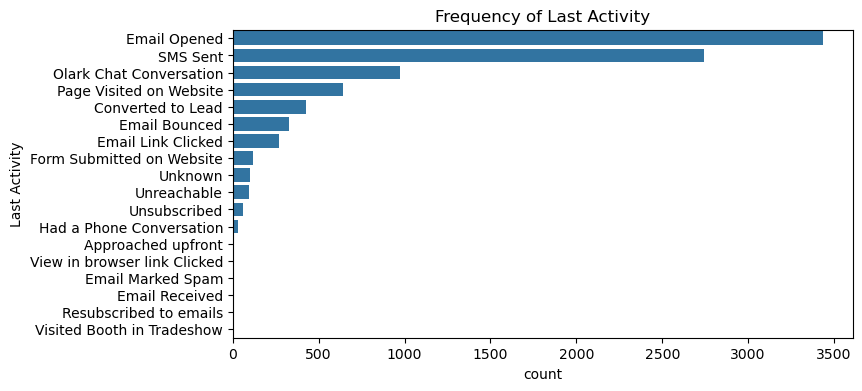

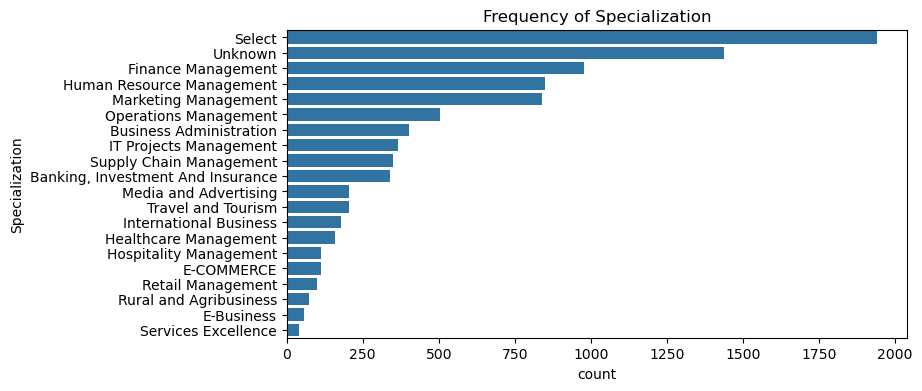

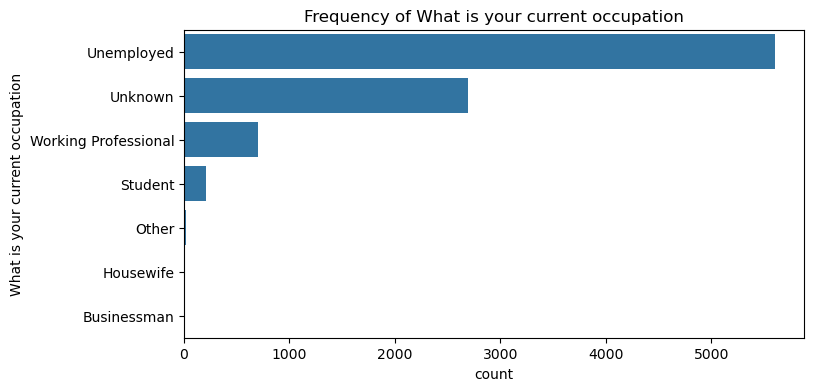

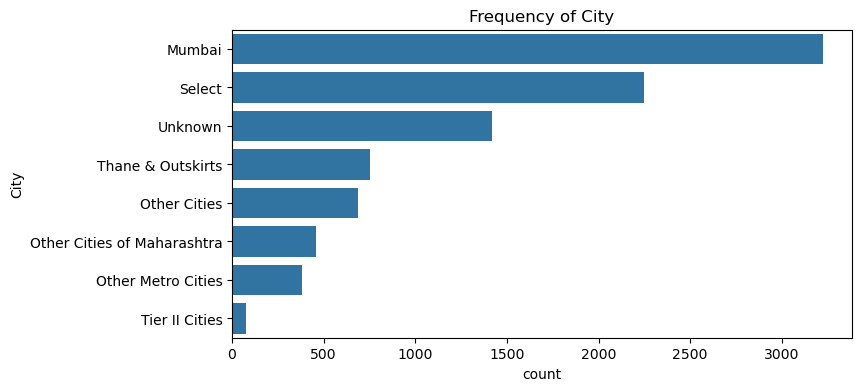

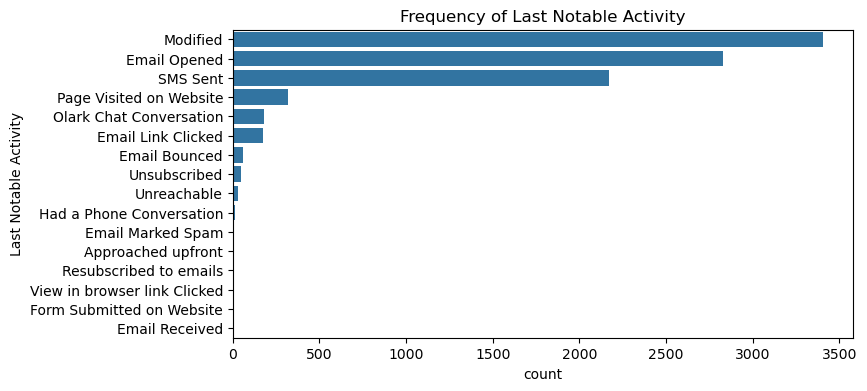

In [54]:
# Categorical Features 
cat_cols = ['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization',
            'What is your current occupation', 'City', 'Last Notable Activity']

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Frequency of {col}')
    plt.show()

### Bi-variate Analysis

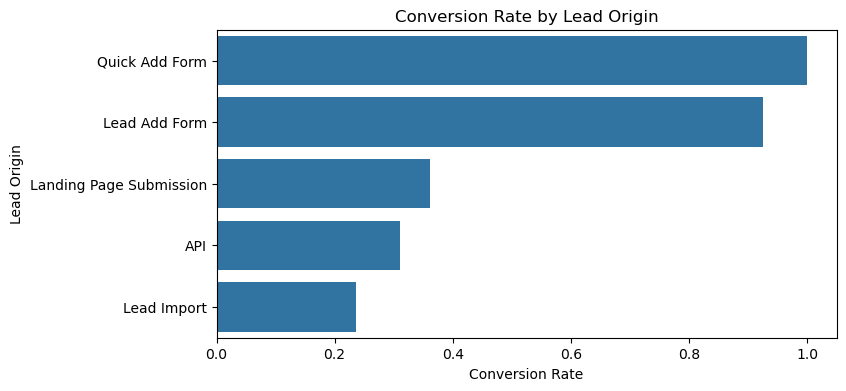

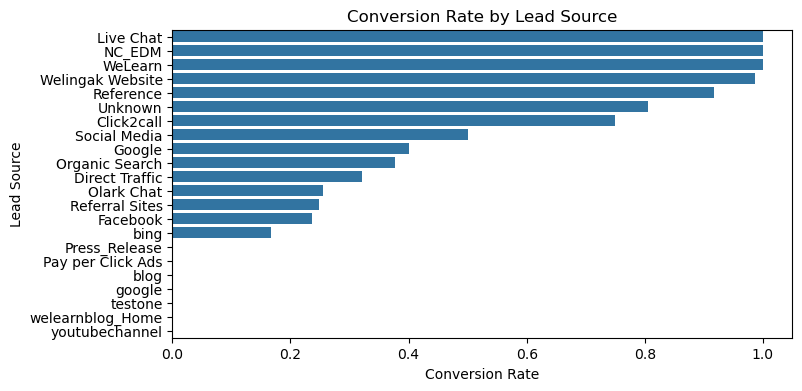

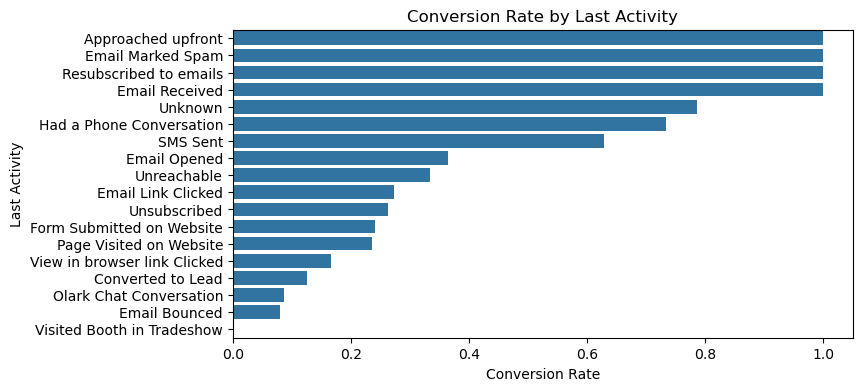

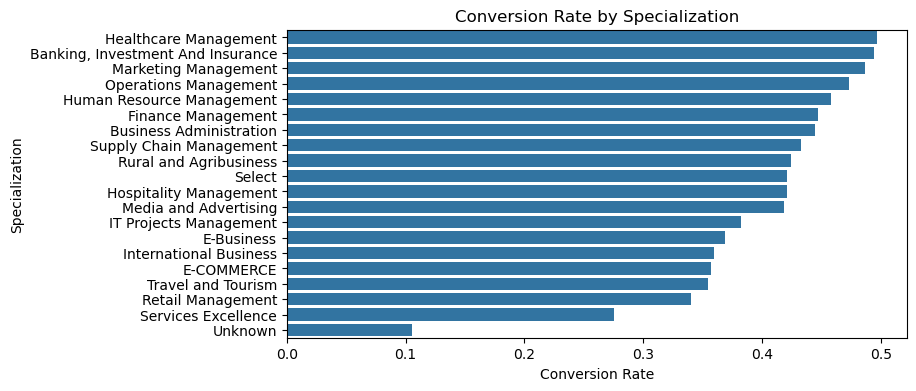

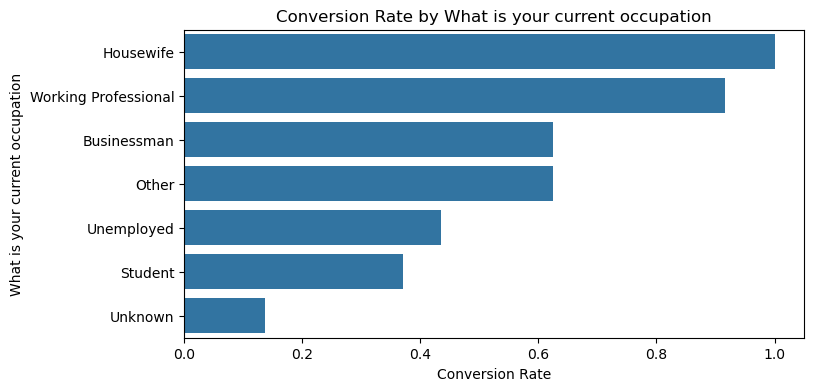

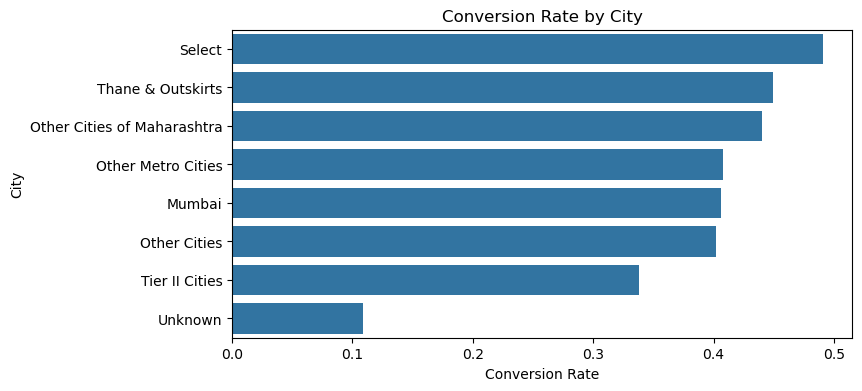

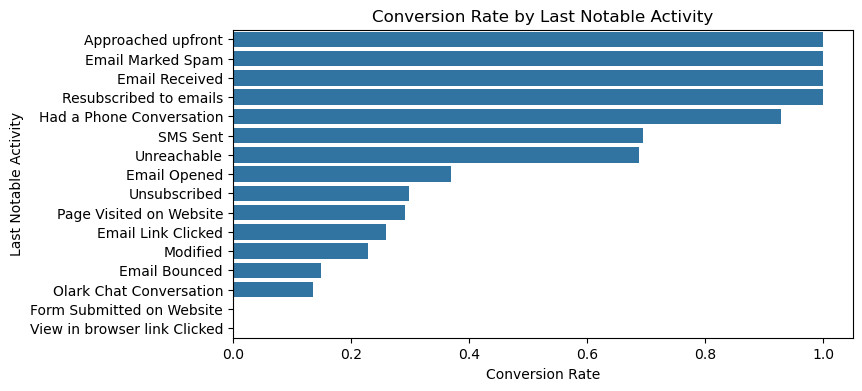

In [55]:
# Categorical vs Target
for col in cat_cols:
    plt.figure(figsize=(8,4))
    conversion_rate = df.groupby(col)['Converted'].mean().sort_values(ascending=False)
    sns.barplot(x=conversion_rate.values, y=conversion_rate.index)
    plt.title(f'Conversion Rate by {col}')
    plt.xlabel('Conversion Rate')
    plt.show()

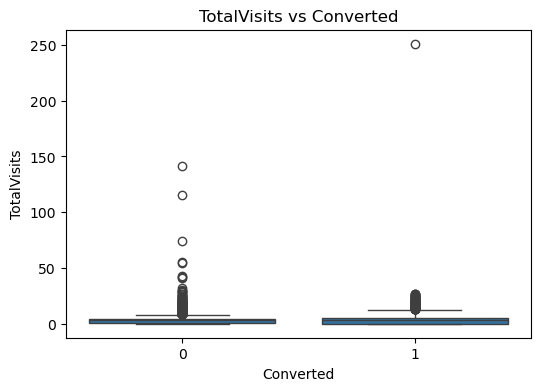

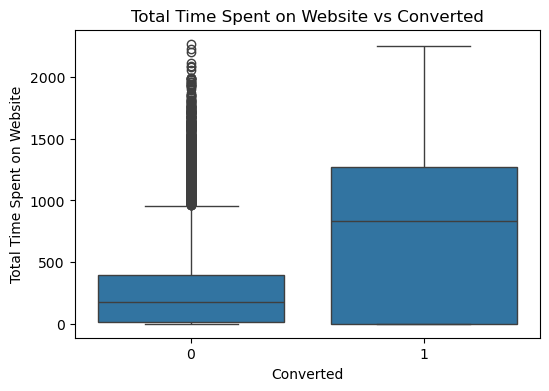

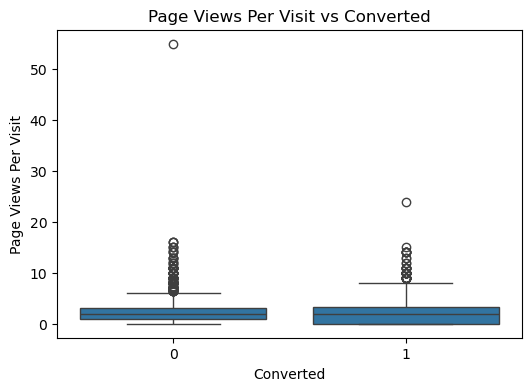

In [56]:
# Numeric Versus Target Variable
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Converted', y=col, data=df)
    plt.title(f'{col} vs Converted')
    plt.show()

In [57]:
# Applying log transformation to skewed features
df['TotalVisits_Log'] = np.log1p(df['TotalVisits'])
df['TotalTimeSpent_Log'] = np.log1p(df['Total Time Spent on Website'])
df['PageViewsPerVisit_Log'] = np.log1p(df['Page Views Per Visit'])

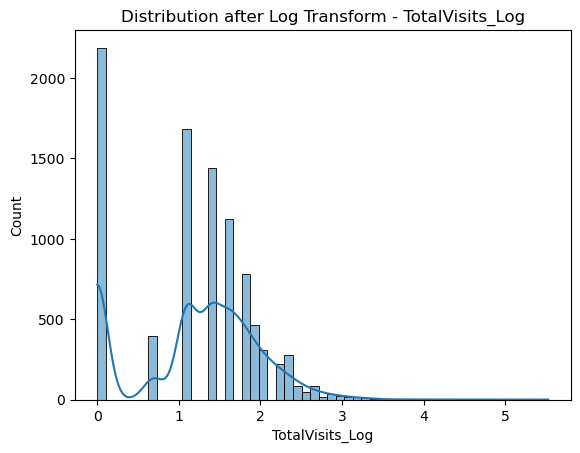

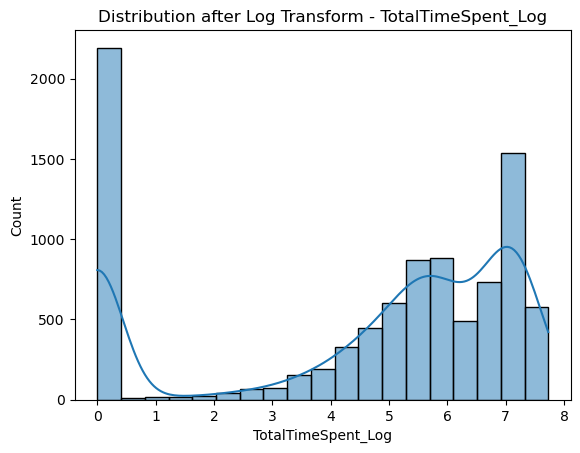

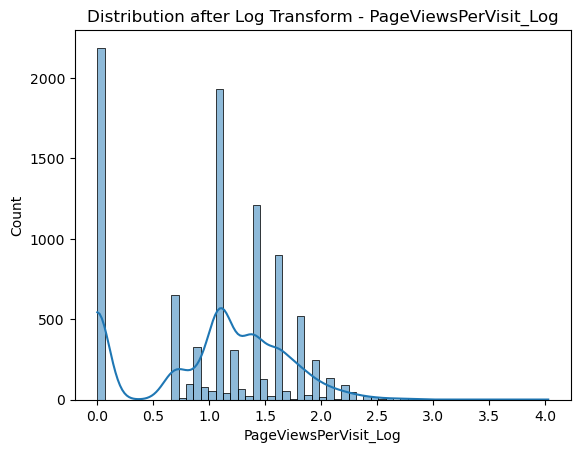

In [58]:
numeric_cols = ['TotalVisits_Log', 'TotalTimeSpent_Log', 'PageViewsPerVisit_Log']
for col in ['TotalVisits_Log', 'TotalTimeSpent_Log', 'PageViewsPerVisit_Log']:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution after Log Transform - {col}')
    plt.show()

In [59]:
# After Applying the log transformation to check the skewness

# 1. Select only numeric columns from your DataFrame
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# 2. Compute skewness for each of those columns
skewness_values = df[numeric_cols].skew().sort_values(ascending=False)

# 3. Print all skewness values
print("Skewness in Numerical Features:")
print(skewness_values)

# 4. Highlight only the highly skewed ones (optional threshold: |skew| > 1)
high_skew = skewness_values[abs(skewness_values) > 1]
print("\n Highly Skewed Features (|skew| > 1):")
print(high_skew)


Skewness in Numerical Features:
Do Not Call                               67.959544
TotalVisits                               20.061230
Do Not Email                               3.110947
Page Views Per Visit                       2.898954
Total Time Spent on Website                0.956450
A free copy of Mastering The Interview     0.808899
Converted                                  0.471058
Receive More Updates About Our Courses     0.000000
TotalVisits_Log                           -0.160649
PageViewsPerVisit_Log                     -0.300001
TotalTimeSpent_Log                        -0.772383
dtype: float64

 Highly Skewed Features (|skew| > 1):
Do Not Call             67.959544
TotalVisits             20.061230
Do Not Email             3.110947
Page Views Per Visit     2.898954
dtype: float64


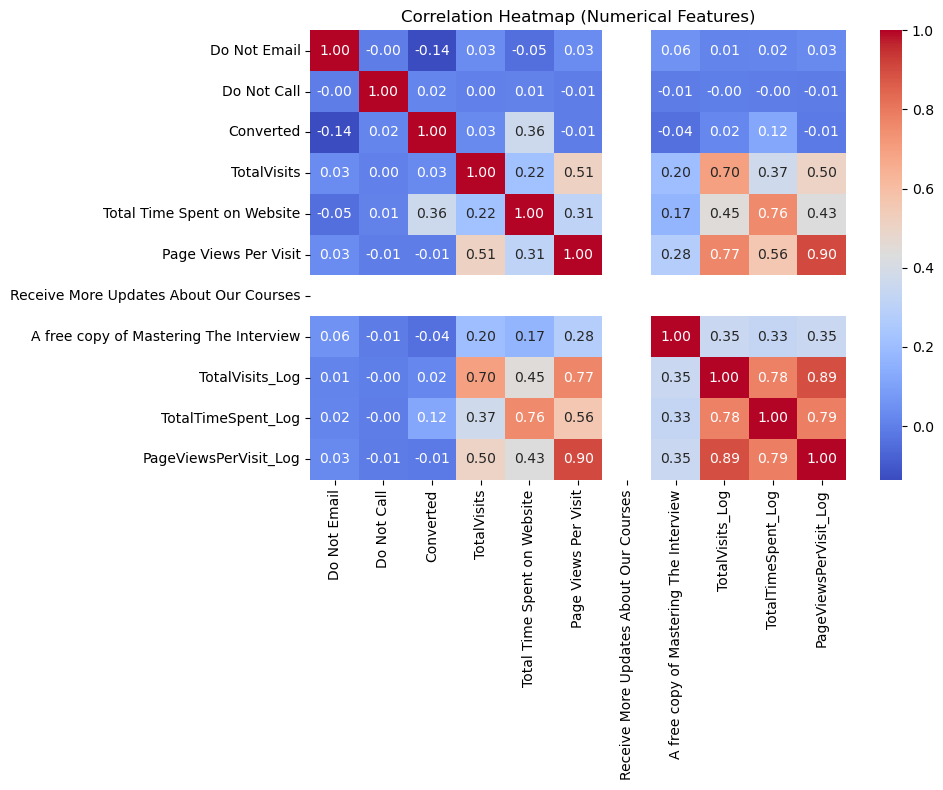

In [62]:
# Correlation features

# Recompute numeric columns to avoid issues
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Make sure 'Converted' is included
if 'Converted' not in numeric_cols:
    numeric_cols.append('Converted')

# Now compute and plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.tight_layout()
plt.show()


🔎 Do Not Email has 734 outliers (IQR bounds: 0.00 - 0.00)


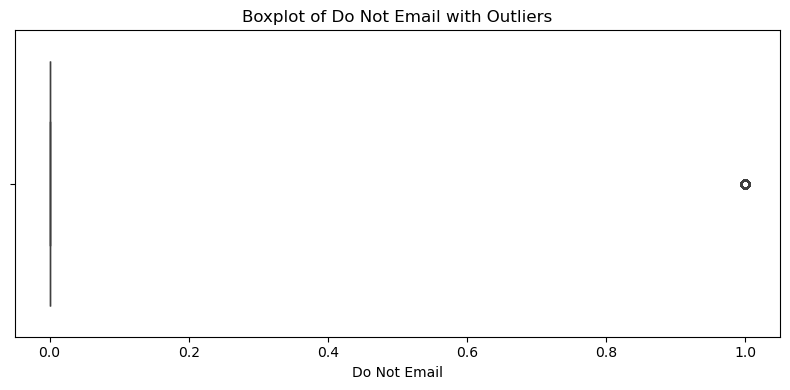

🔎 Do Not Call has 2 outliers (IQR bounds: 0.00 - 0.00)


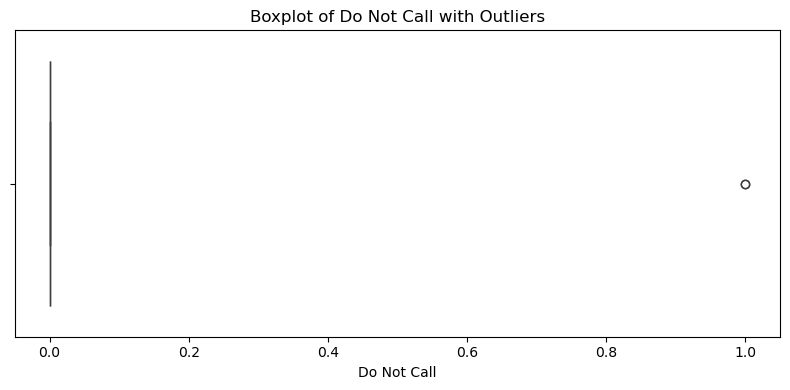

🔎 Converted has 0 outliers (IQR bounds: -1.50 - 2.50)


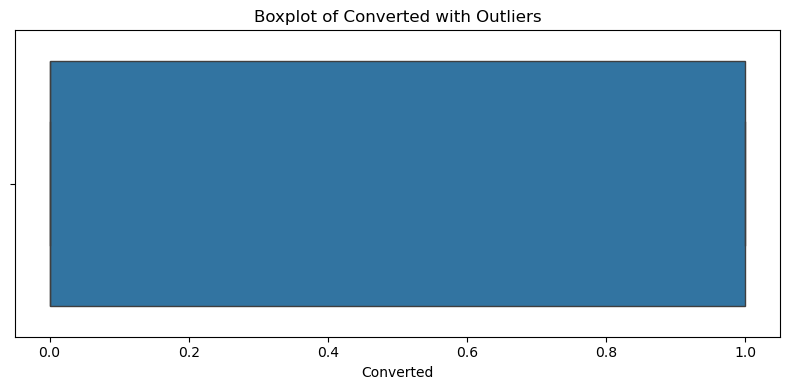

🔎 TotalVisits has 267 outliers (IQR bounds: -5.00 - 11.00)


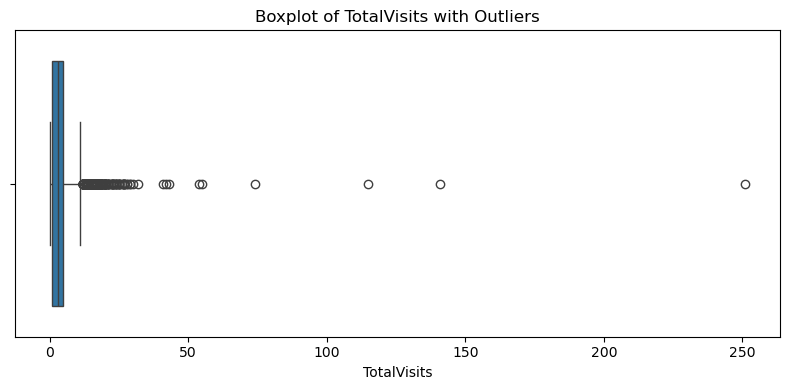

🔎 Total Time Spent on Website has 0 outliers (IQR bounds: -1374.00 - 2322.00)


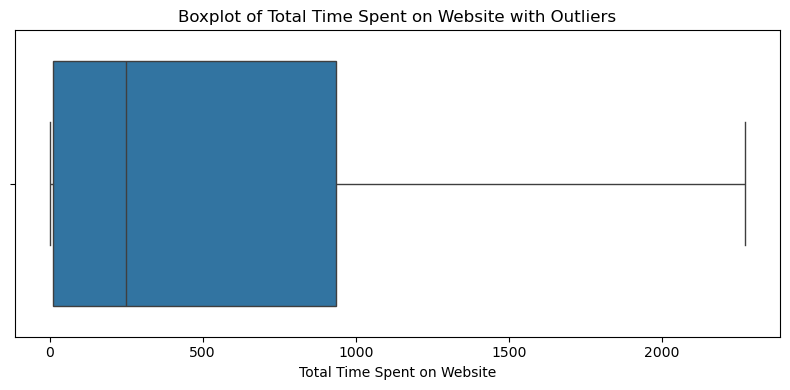

🔎 Page Views Per Visit has 360 outliers (IQR bounds: -2.00 - 6.00)


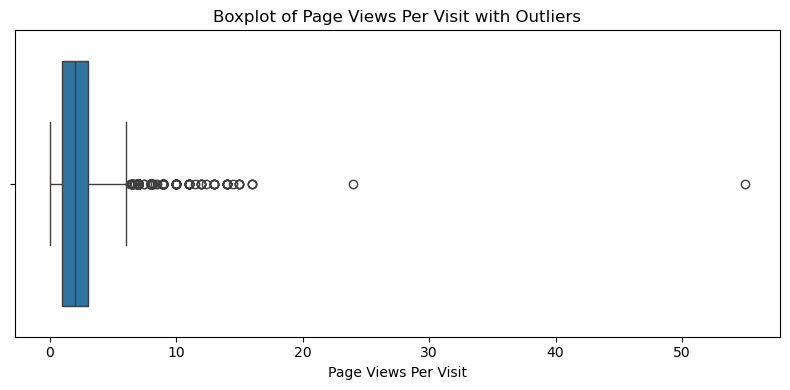

🔎 Receive More Updates About Our Courses has 0 outliers (IQR bounds: 0.00 - 0.00)


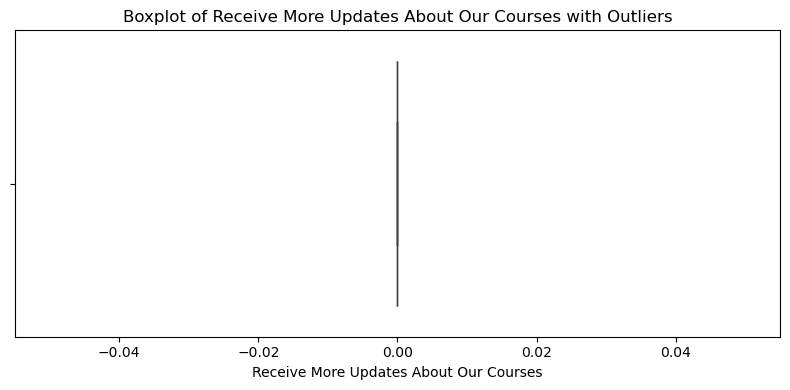

🔎 A free copy of Mastering The Interview has 0 outliers (IQR bounds: -1.50 - 2.50)


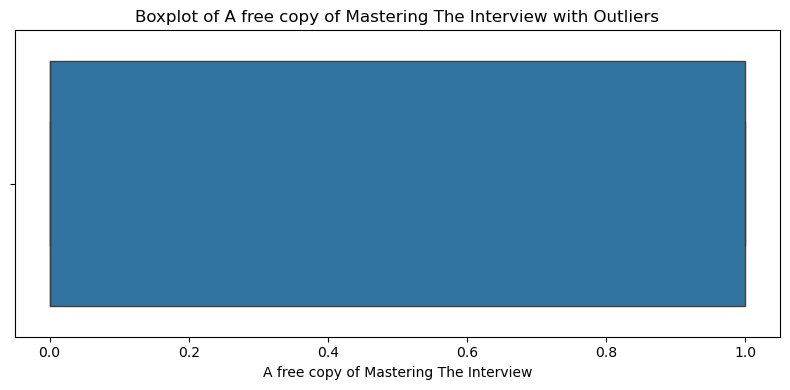

🔎 TotalVisits_Log has 10 outliers (IQR bounds: -0.95 - 3.44)


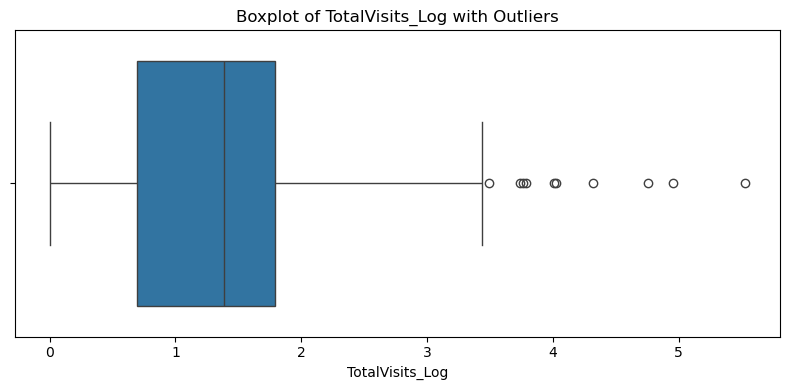

🔎 TotalTimeSpent_Log has 0 outliers (IQR bounds: -3.85 - 13.26)


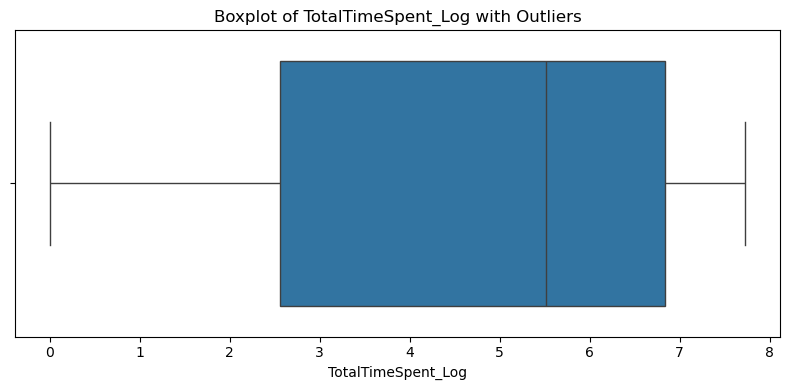

🔎 PageViewsPerVisit_Log has 50 outliers (IQR bounds: -0.35 - 2.43)


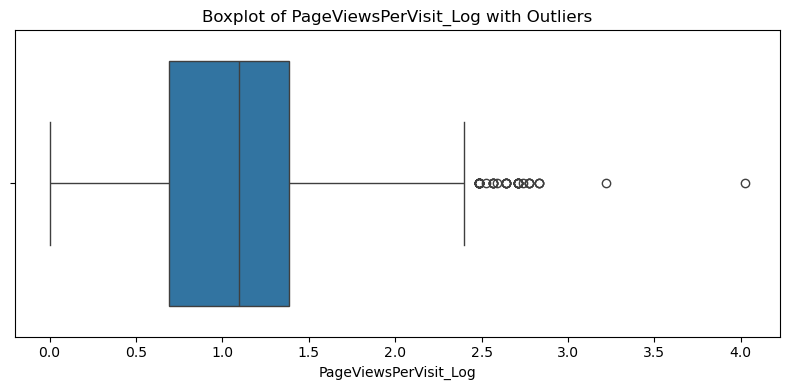

In [67]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Visualize outliers with boxplots
for col in numeric_cols:
    outliers, low, high = detect_outliers_iqr(df, col)
    count = len(outliers)
    print(f"🔎 {col} has {count} outliers (IQR bounds: {low:.2f} - {high:.2f})")

    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col} with Outliers")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


In [66]:
# Step 1: Select only numeric features (excluding target)
features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Converted'], errors='ignore')

# Step 2: Drop rows with NaNs (required for VIF calculation)
features_clean = features.dropna()

# Step 3: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_clean)

# Step 4: Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Step 5: Display
print("Variance Inflation Factor (VIF):")
print(vif_data.sort_values(by="VIF", ascending=False))

Variance Inflation Factor (VIF):
                                  Feature        VIF
9                   PageViewsPerVisit_Log  25.828274
7                         TotalVisits_Log  10.976967
8                      TotalTimeSpent_Log  10.142626
4                    Page Views Per Visit  10.125192
3             Total Time Spent on Website   3.315352
2                             TotalVisits   2.745036
6  A free copy of Mastering The Interview   1.164829
0                            Do Not Email   1.018524
1                             Do Not Call   1.000545
5  Receive More Updates About Our Courses        NaN


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
